# Figure2(Stackedbar) for tag

In [1]:
# create table tt_tag_proportion as
# select to_char(xx.creationdate, 'yyyy-mm-dd') as cdate , xx.id, xx.tag, xx.cnt, yy.tot_cnt, xx.cnt::FLOAT /yy.tot_cnt as pct
#   from (
#        select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag, 1 as cnt
#         from public.posts
#         where posttypeid = '1'
#           and creationdate between '2021-11-30' and '2023-12-01'
#           and tags like '%<python>%'

#            ) xx,
#        (
#            select x.id, count(x.tag) as tot_cnt
#               from (select creationdate, id, tags, replace(replace(unnest(string_to_array(tags, '><')), '<', ''), '>', '') tag
#                       from public.posts
#                     where posttypeid = '1'
#                       and creationdate between '2021-11-30' and '2023-12-01'
#                       and tags like '%<python>%') x
#             group by x.id

#            )yy
# where xx.id = yy.id
# ;

In [2]:
import sys, os
p = os.path.abspath('..')
sys.path.insert(1, p)

pp = os.path.abspath('../../visualization')
sys.path.insert(1, pp)

In [3]:
from gc import collect

import pickle
import lib.stats.stats as st
from utils.statistics import *
from utils.settings import set_matplotlib
from distribution_collector import (collect_topic_distributions,
                                get_top_and_bottom_topics,
                                extract_specific_topics,
                                collect_tag_distributions)
from constants import CONSTANTS
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib as mpl

import psycopg2
import pandas as pd
import numpy as np
from utils.statistics import *
import config.config as conf
import datetime
import re
# 포뮬러 구성
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd


In [4]:
from matplotlib import font_manager
import matplotlib as mpl
from matplotlib import font_manager as fm

# 설치된 폰트 이름과 경로 확인
for font in font_manager.fontManager.ttflist:
    if 'Helvetica' in font.name: # 'Nanum' 대신 원하는 글꼴의 일부를 입력하여 검색할 수 있습니다.
        print(font.name, font.fname)

# 직접 경로로 Helvetica 폰트 불러오기
font_path = "/System/Library/Fonts/Helvetica.ttc"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
print(f"Registered font name: {font_name}")

mpl.rcParams['font.family'] = font_name


Helvetica /System/Library/Fonts/Helvetica.ttc
Helvetica Neue /System/Library/Fonts/HelveticaNeue.ttc
Registered font name: Helvetica


In [5]:
output_dir = './fig/'

In [6]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute("\
           select * \
           from tt_tag_proportion a \
; \
                " 
   )
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [7]:
df = pd.DataFrame(rows, columns = [
  'cdate' 
, 'id' 
, 'tag'
, 'cnt'
, 'tot_cnt'
, 'pct'
])

In [8]:
conn = psycopg2.connect(host = conf.database_user['host'], dbname=conf.database_user['dbname'], user=conf.database_user['user'], password=conf.database_user['password'])
try:
    cur = conn.cursor()
    cur.execute("\
           select * \
           from tt_tag_proportio_for_did a \
; \
                " 
   )
    rows = cur.fetchall()
    

except psycopg2.DatabaseError as db_err:
    print(db_err)
finally : 
  cur.close()

In [9]:
df_did = pd.DataFrame(rows, columns = [
  'cdate' 
, 'id' 
, 'tag'
, 'cnt'
, 'tot_cnt'
, 'pct'
])

In [10]:
std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

In [11]:
df['cdate'] = pd.to_datetime(df['cdate'], format="%Y-%m-%d")
df_did['cdate'] = pd.to_datetime(df_did['cdate'], format="%Y-%m-%d")

In [12]:
df['rel_week'] = np.floor((df['cdate']-std_date).dt.days/7)

df_did['post_rel_week'] = np.floor((df_did['cdate']-std_date).dt.days/7)
df_did['pre_rel_week'] = np.floor((df_did['cdate']-pre_std_date).dt.days/7)

In [13]:
# 상위, 하위 태그 리스트 추출
df_bf_pro = df[df['rel_week']<0].groupby(['tag']).sum(['pct'])['pct'].sort_values().reset_index()
tagnum = int(np.floor(df_bf_pro.shape[0]*0.2))
bot_tag = list(df_bf_pro.iloc[:tagnum, 0])
top_tag = list(df_bf_pro.iloc[tagnum:, 0])

In [14]:
# 일자별로 토픽별 비율을 계산
df_did_tot = df_did.groupby(['cdate']).sum(['pct'])['pct'].reset_index(name = 'tot_pct')
df_pct = pd.merge(df_did, df_did_tot, on = 'cdate')
df_pct['pct_byday'] = df_pct['pct']/df_pct['tot_pct']

# 상위 하위에 포함되는 태그만 추출
df_pct_top = df_pct[df_pct['tag'].isin(top_tag)].reset_index(drop=True)
df_pct_bot = df_pct[df_pct['tag'].isin(bot_tag)].reset_index(drop=True)

#DID수행을 위해서 top/bottom에 대한  pre/post추출
df_top_af = df_pct_top[(df_pct_top['post_rel_week'] >=-20) & (df_pct_top['post_rel_week'] <20)  ]
df_top_bf = df_pct_top[(df_pct_top['pre_rel_week'] >=-20) & (df_pct_top['pre_rel_week'] <20)  ]

df_bot_af = df_pct_bot[(df_pct_bot['post_rel_week'] >=-20) & (df_pct_bot['post_rel_week'] <20)  ]
df_bot_bf = df_pct_bot[(df_pct_bot['pre_rel_week'] >=-20) & (df_pct_bot['pre_rel_week'] <20)  ]

# DiD  수행시 필요한 계수 (post treat) 추출
df_top_af.loc[:, 'treated'] = 1
df_top_bf.loc[:, 'treated'] = 0

df_bot_af.loc[:, 'treated'] = 1
df_bot_bf.loc[:, 'treated'] = 0

df_top_af.loc[:, 'post'] = np.where(df_top_af['post_rel_week']<0, 0, 1)
df_top_bf.loc[:, 'post'] = np.where(df_top_bf['pre_rel_week']<0, 0, 1)

df_bot_af.loc[:, 'post'] = np.where(df_bot_af['post_rel_week']<0, 0, 1)
df_bot_bf.loc[:, 'post'] = np.where(df_bot_bf['pre_rel_week']<0, 0, 1)



df_top_bf = df_top_bf.rename(columns= {'pre_rel_week':'rel_week'})
df_bot_bf = df_bot_bf.rename(columns= {'pre_rel_week':'rel_week'})

df_top_af = df_top_af.rename(columns= {'post_rel_week':'rel_week'})
df_bot_af = df_bot_af.rename(columns= {'post_rel_week':'rel_week'})



df_bot_for_did = pd.concat([df_bot_bf[['rel_week', 'pct', 'treated', 'post']], df_bot_af[['rel_week', 'pct', 'treated', 'post']]])
df_top_for_did = pd.concat([df_top_bf[['rel_week', 'pct', 'treated', 'post']], df_top_af[['rel_week', 'pct', 'treated', 'post']]])





/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_2620/3500684997.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_af.loc[:, 'treated'] = 1
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_2620/3500684997.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bf.loc[:, 'treated'] = 0
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_2620/3500684997.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [15]:
def calc_did(data, measure):
    data['rel_week'] = data['rel_week'].astype('category')
    # 회귀식: 주차별 상호작용 포함
    model = smf.ols(f"{measure} ~ C(rel_week) * treated", data=data)
    did_result = model.fit(cov_type='HAC', cov_kwds={'maxlags': 7}) 

    return did_result

In [16]:
def pp_did_result(did_result) :
    # 결과 정리
    periods = np.arange(-19,19, 1)
    coefs = did_result.params
    std_errors = did_result.bse 
    conf = did_result.conf_int()
    print(coefs)
    coefs_filtered      = coefs.loc[[f'C(rel_week)[T.{i}.0]:treated' for i in periods]].values
    std_errors_filtered = std_errors.loc[[f'C(rel_week)[T.{i}.0]:treated' for i in periods]].values

    # 신뢰구간 계산
    ll_95 = coefs_filtered - 1.965 * std_errors_filtered
    ul_95 = coefs_filtered + 1.965 * std_errors_filtered

    # 데이터프레임 생성 (계수와 신뢰구간)
    df_coefs = pd.DataFrame({
        'period'    : periods,
        'Estimate'  : coefs_filtered,
        'll_95'     : ll_95,
        'ul_95'     : ul_95
    })
    return df_coefs




In [17]:
df_top_for_did

,rel_week,pct,treated,post
54189,5.0,0.20,0,1
54190,5.0,0.20,0,1
54191,5.0,0.20,0,1
54192,5.0,0.20,0,1
54193,5.0,0.20,0,1
...,...,...,...,...
1914013,-20.0,0.25,1,0
1914022,-20.0,0.25,1,0
1914023,-20.0,0.25,1,0
1914024,-20.0,0.25,1,0


In [18]:
top_did_result = calc_did(df_top_for_did, 'pct')
bot_did_result = calc_did(df_bot_for_did , 'pct')

top_event_effects = pp_did_result(top_did_result)
bot_event_effects = pp_did_result(bot_did_result)


Intercept                      0.306359
C(rel_week)[T.-19.0]           0.004993
C(rel_week)[T.-18.0]           0.001128
C(rel_week)[T.-17.0]           0.001454
C(rel_week)[T.-16.0]          -0.000531
                                 ...   
C(rel_week)[T.15.0]:treated   -0.012043
C(rel_week)[T.16.0]:treated   -0.008713
C(rel_week)[T.17.0]:treated   -0.009844
C(rel_week)[T.18.0]:treated   -0.012238
C(rel_week)[T.19.0]:treated   -0.020385
Length: 80, dtype: float64
Intercept                      0.246099
C(rel_week)[T.-19.0]           0.003494
C(rel_week)[T.-18.0]           0.016826
C(rel_week)[T.-17.0]           0.013657
C(rel_week)[T.-16.0]           0.002419
                                 ...   
C(rel_week)[T.15.0]:treated    0.075393
C(rel_week)[T.16.0]:treated    0.057825
C(rel_week)[T.17.0]:treated    0.085341
C(rel_week)[T.18.0]:treated    0.067477
C(rel_week)[T.19.0]:treated    0.078258
Length: 80, dtype: float64


In [ ]:
tag_event_effects_dict = dict()
tag_event_effects_dict['Tags : Top 20% DID'] = top_event_effects
tag_event_effects_dict['Tags : Bottom 20% DID'] = bot_event_effects

In [22]:
data_dir = f'../../visualization/{CONSTANTS.bert_monthly_data_dir_3[3:]}'
lst = os.listdir(data_dir)
df = pd.DataFrame()
# 디렉토리 내의 파일을 for 문으로 반복
for i in lst:
	js = load_json(f'{data_dir}/{i}')
	tmp = pd.DataFrame(js)
	df = pd.concat([df, tmp], axis = 0)

In [23]:
print(data_dir)

../../visualization/result/bert_based/run_id_3/data


In [24]:
sorted(lst)

['0.json',
 '1.json',
 '10.json',
 '11.json',
 '12.json',
 '13.json',
 '14.json',
 '15.json',
 '16.json',
 '17.json',
 '18.json',
 '19.json',
 '2.json',
 '20.json',
 '21.json',
 '22.json',
 '23.json',
 '24.json',
 '25.json',
 '26.json',
 '27.json',
 '28.json',
 '29.json',
 '3.json',
 '30.json',
 '31.json',
 '32.json',
 '33.json',
 '34.json',
 '35.json',
 '36.json',
 '37.json',
 '38.json',
 '39.json',
 '4.json',
 '40.json',
 '41.json',
 '42.json',
 '43.json',
 '44.json',
 '45.json',
 '46.json',
 '47.json',
 '48.json',
 '49.json',
 '5.json',
 '50.json',
 '51.json',
 '52.json',
 '53.json',
 '54.json',
 '55.json',
 '56.json',
 '57.json',
 '58.json',
 '59.json',
 '6.json',
 '60.json',
 '61.json',
 '62.json',
 '63.json',
 '7.json',
 '8.json',
 '9.json']

In [25]:
print(df['creationdate'].min())
print(df['creationdate'].max())

2020-11-30 00:04:44.453000
2023-11-30 23:52:28.800000


In [26]:
df = df[['id', 'creationdate', 'Topic']].copy()

In [27]:
# ----> 1 top10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][:10])
#       2 bot10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][-10:])

In [28]:
df['creationdate'] = pd.to_datetime(df['creationdate'], format="mixed")
df['cdate'] = pd.to_datetime(df['creationdate'], format="%Y-%m-%d").dt.date
df['cdate'] = pd.to_datetime(df['cdate'], format="%Y-%m-%d")


In [29]:
top10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][:10])
bot10list = list(df[(df['cdate']>='2021-11-30')&(df['cdate']<'2022-11-30')].groupby('Topic').count()['id'].reset_index().sort_values(by = 'id', ascending=False)['Topic'][-10:])

In [30]:
df_did = df.groupby(['cdate', 'Topic']).count()['id'].reset_index(name = 'cnt')

In [31]:
df_did.loc[df_did['cdate'] =='2020-11-30', 'cnt'].sum()

794

In [32]:
std_date = datetime.datetime(2022, 11, 30)
pre_std_date = datetime.datetime(2021, 12, 1)

df_did['post_rel_week'] = np.floor((df_did['cdate']-std_date).dt.days/7)
df_did['pre_rel_week'] = np.floor((df_did['cdate']-pre_std_date).dt.days/7)

In [33]:
# 일자별로 토픽별 비율을 계산
df_did_tot = df_did.groupby(['cdate']).sum(['cnt'])['cnt'].reset_index(name = 'tot_cnt')
df_pct = pd.merge(df_did, df_did_tot, on = 'cdate')
df_pct['pct_byday'] = df_pct['cnt']/df_pct['tot_cnt']

# 상위 하위에 포함되는 태그만 추출
df_pct_top = df_pct[df_pct['Topic'].isin(top10list)].reset_index(drop=True)
df_pct_bot = df_pct[df_pct['Topic'].isin(bot10list)].reset_index(drop=True)

#DID수행을 위해서 top/bottom에 대한  pre/post추출
df_top_af = df_pct_top[(df_pct_top['post_rel_week'] >=-20) & (df_pct_top['post_rel_week'] <20)  ]
df_top_bf = df_pct_top[(df_pct_top['pre_rel_week'] >=-20) & (df_pct_top['pre_rel_week'] <20)  ]

df_bot_af = df_pct_bot[(df_pct_bot['post_rel_week'] >=-20) & (df_pct_bot['post_rel_week'] <20)  ]
df_bot_bf = df_pct_bot[(df_pct_bot['pre_rel_week'] >=-20) & (df_pct_bot['pre_rel_week'] <20)  ]

# DiD  수행시 필요한 계수 (post treat) 추출
df_top_af.loc[:, 'treated'] = 1
df_top_bf.loc[:, 'treated'] = 0

df_bot_af.loc[:, 'treated'] = 1
df_bot_bf.loc[:, 'treated'] = 0

df_top_af.loc[:, 'post'] = np.where(df_top_af['post_rel_week']<0, 0, 1)
df_top_bf.loc[:, 'post'] = np.where(df_top_bf['pre_rel_week']<0, 0, 1)

df_bot_af.loc[:, 'post'] = np.where(df_bot_af['post_rel_week']<0, 0, 1)
df_bot_bf.loc[:, 'post'] = np.where(df_bot_bf['pre_rel_week']<0, 0, 1)



df_top_bf = df_top_bf.rename(columns= {'pre_rel_week':'rel_week'})
df_bot_bf = df_bot_bf.rename(columns= {'pre_rel_week':'rel_week'})

df_top_af = df_top_af.rename(columns= {'post_rel_week':'rel_week'})
df_bot_af = df_bot_af.rename(columns= {'post_rel_week':'rel_week'})



df_bot_for_did = pd.concat([df_bot_bf[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']], df_bot_af[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']]])
df_top_for_did = pd.concat([df_top_bf[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']], df_top_af[['rel_week', 'cdate', 'pct_byday', 'treated', 'post']]])





/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_2620/3598514678.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_af.loc[:, 'treated'] = 1
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_2620/3598514678.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_bf.loc[:, 'treated'] = 0
/var/folders/lk/t243gzpx379bzd9mvx8dcsmm0000gp/T/ipykernel_2620/3598514678.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [34]:
# df_bot_bf.loc[df_bot_bf['cdate'] =='2021-08-18', 'cnt'].sum()

In [35]:
# df_bot_bf

In [36]:
# df_bot_for_did
# df_top_for_did

In [37]:
# df_bot_for_did = df_bot_for_did.groupby(['rel_week', 'cdate', 'treated', 'post']).sum()['pct_byday'].reset_index()
# df_top_for_did = df_top_for_did.groupby(['rel_week', 'cdate', 'treated', 'post']).sum()['pct_byday'].reset_index()

In [38]:
df_top_for_did[(df_top_for_did['rel_week'] ==-20)&(df_top_for_did['cdate'] =='2021-07-14')]

,rel_week,cdate,pct_byday,treated,post
2260,-20.0,2021-07-14,0.046683,0,0
2261,-20.0,2021-07-14,0.063882,0,0
2262,-20.0,2021-07-14,0.051597,0,0
2263,-20.0,2021-07-14,0.034398,0,0
2264,-20.0,2021-07-14,0.025799,0,0
2265,-20.0,2021-07-14,0.027027,0,0
2266,-20.0,2021-07-14,0.039312,0,0
2267,-20.0,2021-07-14,0.031941,0,0
2268,-20.0,2021-07-14,0.030713,0,0
2269,-20.0,2021-07-14,0.029484,0,0


In [39]:
top_did_result = calc_did(df_top_for_did, 'pct_byday')
bot_did_result = calc_did(df_bot_for_did , 'pct_byday')

top_event_effects = pp_did_result(top_did_result)
bot_event_effects = pp_did_result(bot_did_result)


Intercept                      0.036783
C(rel_week)[T.-19.0]           0.001549
C(rel_week)[T.-18.0]           0.000166
C(rel_week)[T.-17.0]          -0.001395
C(rel_week)[T.-16.0]           0.001166
                                 ...   
C(rel_week)[T.15.0]:treated   -0.003339
C(rel_week)[T.16.0]:treated   -0.002968
C(rel_week)[T.17.0]:treated   -0.001901
C(rel_week)[T.18.0]:treated   -0.002093
C(rel_week)[T.19.0]:treated   -0.002793
Length: 80, dtype: float64
Intercept                      0.007778
C(rel_week)[T.-19.0]           0.000264
C(rel_week)[T.-18.0]          -0.000406
C(rel_week)[T.-17.0]           0.000928
C(rel_week)[T.-16.0]           0.000051
                                 ...   
C(rel_week)[T.15.0]:treated    0.003258
C(rel_week)[T.16.0]:treated    0.003687
C(rel_week)[T.17.0]:treated    0.003714
C(rel_week)[T.18.0]:treated    0.005717
C(rel_week)[T.19.0]:treated    0.005377
Length: 80, dtype: float64


In [ ]:
bertopic_event_effects_dict = dict()
bertopic_event_effects_dict['BERTopic : Top 20% DID'] = top_event_effects
bertopic_event_effects_dict['BERTopic : Bottom 20% DID'] = bot_event_effects

In [48]:
event_effects_dict = {'BERTopic' :bertopic_event_effects_dict, 'Tag' :tag_event_effects_dict}

tag_event_effects_dict

{'Top 20% Tags DID':     period  Estimate     ll_95     ul_95
 0      -19 -0.005737 -0.011872  0.000398
 1      -18  0.002318 -0.003858  0.008493
 2      -17  0.002152 -0.004061  0.008365
 3      -16 -0.000218 -0.006360  0.005923
 4      -15 -0.002043 -0.008171  0.004085
 5      -14 -0.002095 -0.008270  0.004079
 6      -13 -0.000458 -0.006798  0.005882
 7      -12  0.001288 -0.005047  0.007623
 8      -11  0.002799 -0.003556  0.009153
 9      -10  0.002395 -0.003912  0.008701
 10      -9  0.011049  0.004595  0.017502
 11      -8 -0.005476 -0.011900  0.000947
 12      -7  0.002302 -0.004076  0.008679
 13      -6  0.002344 -0.003977  0.008664
 14      -5 -0.000159 -0.006486  0.006168
 15      -4 -0.005550 -0.011706  0.000607
 16      -3 -0.007542 -0.013702 -0.001382
 17      -2 -0.006589 -0.012706 -0.000473
 18      -1 -0.005992 -0.012184  0.000199
 19       0 -0.009864 -0.015967 -0.003761
 20       1 -0.007732 -0.013783 -0.001680
 21       2 -0.010737 -0.016869 -0.004606
 22       3 -0

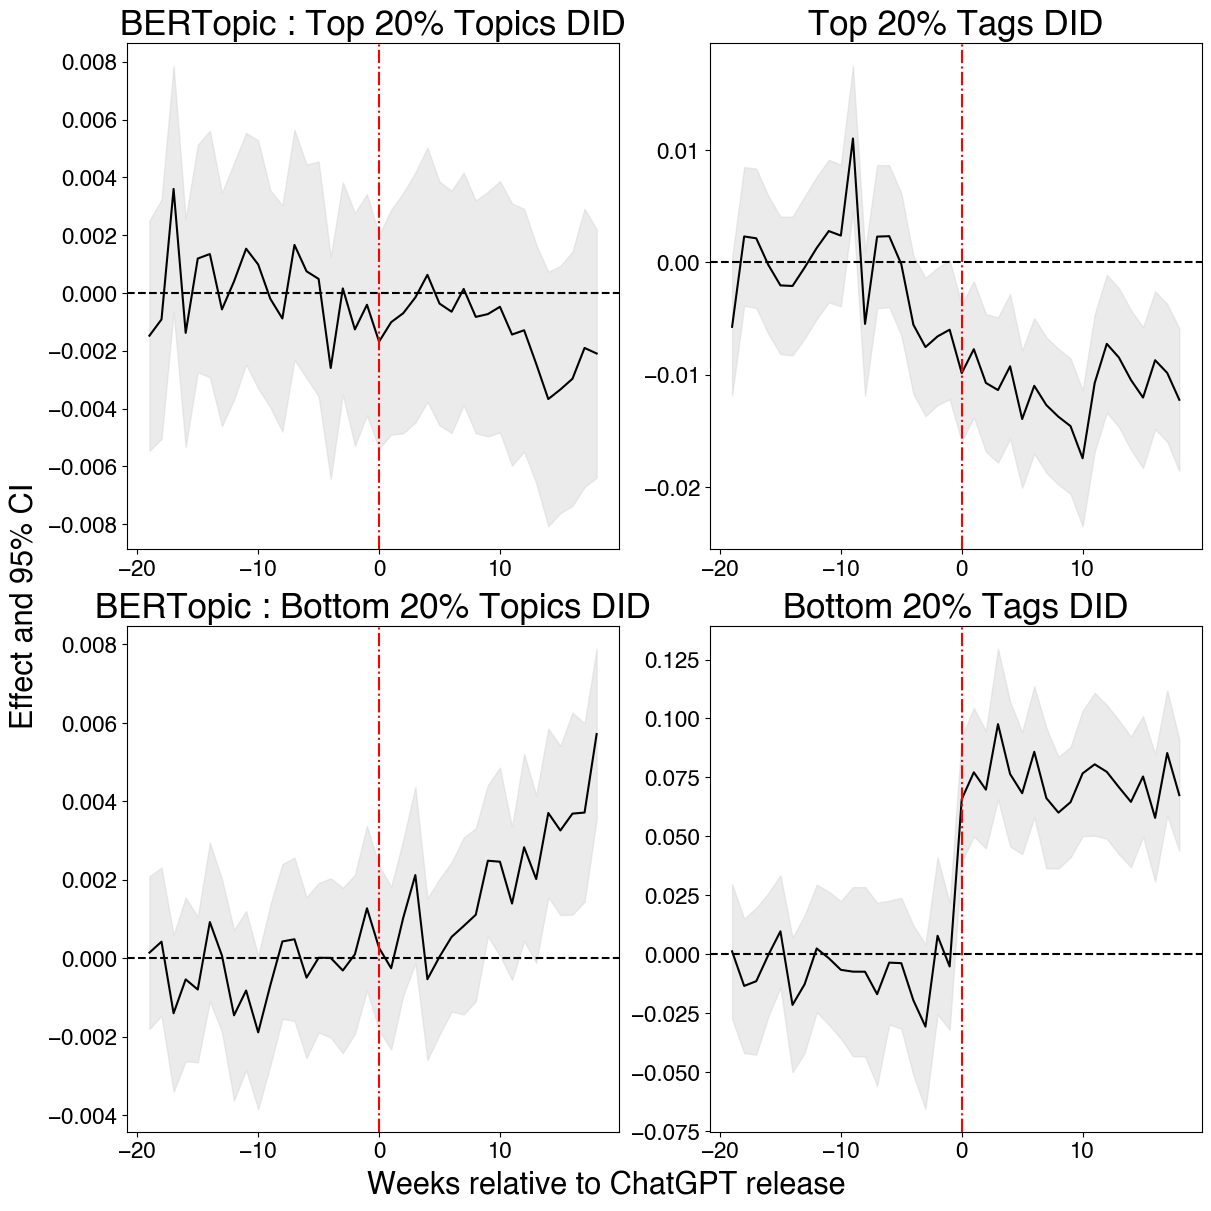

In [52]:

### create a figure with multiple subplots
sharey = True ## 또는 sharey=False
sharex = True ## 또는 sharex=False
# g_num  = len(proportion_dict.items())

fig, axs = plt.subplots(2, 2, figsize = (12, 12), constrained_layout=True)
colors = plt.get_cmap('tab20').colors 


for x, app in enumerate(event_effects_dict):
    effect_dict = event_effects_dict[app]

    for idx, measure in enumerate(effect_dict):
        axs[idx][x].fill_between(effect_dict[measure]['period'], effect_dict[measure]['ll_95'], effect_dict[measure]['ul_95'], color='#CFCFCF', alpha=0.4)
        axs[idx][x].plot(effect_dict[measure]['period'], effect_dict[measure]['Estimate'], color='black', label='DID Estimate')

        # 기준선
        axs[idx][x].axhline(0, linestyle='--', color='black')
        axs[idx][x].axvline(0, linestyle='dashdot', color='red', label='ChatGPT Release')

        # 축 라벨과 제목
        axs[idx][x].set_title(f"{measure}", fontsize=25)
        # axs[x][idx].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

        # axs[x][idx].set_ylim(-0.009, 0.008)
        # axs[x][idx].set_yticks(np.arange(-0.009, 0.008, 0.003))
        
        axs[idx][x].tick_params(axis='x', labelsize=16)
        axs[idx][x].tick_params(axis='y', labelsize=16)

fig.supxlabel("Weeks relative to ChatGPT release", fontsize=22) 
fig.supylabel(f"Effect and 95% CI", fontsize = 22)

plt.savefig(f"{output_dir}SI_4.A.3_Fig13.png", dpi=300, bbox_inches='tight')
plt.show();